## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
ks_ecol_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
samp_num = '2'

# Defining functions

In [9]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [10]:
def determine_enrichment(targ_ks, all_ks, N_cats, max_ks):
    ratios = []
    sections = split_equal(max_ks, N_cats)
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat < sections[0]])/len(all_ks.ks_stat[all_ks.ks_stat < sections[0]]))
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            ratios.append(len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i+1])]
                )/len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i+1])]))
        except:
            pass
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])/len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]]))
    return ratios, sections

In [11]:
def det_p_values(targ_ks, all_ks, sections):
    p_values = []
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(targ_ks)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

## Calculate the KS stat of all of the genes with polyproline motifs in the E.coli data

In [12]:
# Load up the target gene names. 
PPP_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/' + 'polyproline_motifs.csv')

# Load up the tables of KS statistics
df_ecol = pd.read_csv(ks_ecol_path + "ks_table_" + samp_num + ".csv")

In [13]:
# Correct the column headings and rows for the polyproline table. 
PPP_table.columns = PPP_table.iloc[2]
PPP_table = PPP_table.drop([0,1,2])

# Remove the many unecessary columns from the polyproline data
PPP_table = pd.DataFrame(PPP_table.Gene.unique(), columns = ["Gene"])

# Merge the ecoli ks table with the list of gene names
PPP_ks_table = pd.merge(df_ecol, PPP_table, how='inner', right_on='Gene', left_on='gene_ID')

In [14]:
# Several genes have multiple polyproline motifs and thus appear multiple times in the PPP table
# Keep only one copy of each gene in the PPP table. 
PPP_ks_table.sort_values("Gene", inplace = True)
PPP_ks_table.drop_duplicates(subset ="Gene",keep = "first", inplace = True) 

(0.0, 0.7)

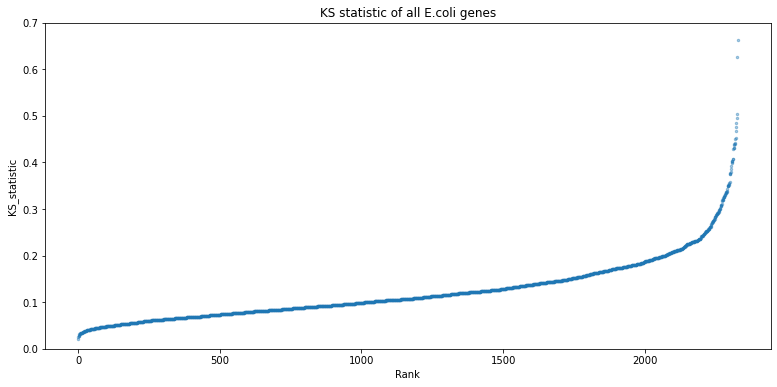

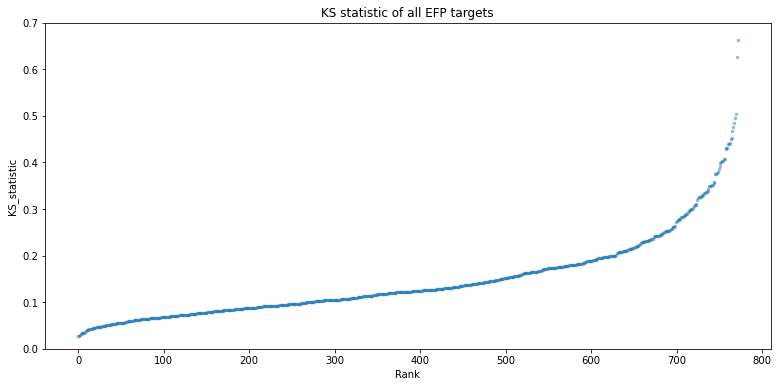

In [15]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_ecol["ks_stat"]))), sorted(df_ecol["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(PPP_ks_table["ks_stat"]))), sorted(PPP_ks_table["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

In [16]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of EFP target genes = " + str(np.mean(PPP_ks_table.ks_stat)))
print("mean KS statistic of all E.coli genes = " + str(np.mean(df_ecol.ks_stat)))

mean KS statistic of EFP target genes = 0.14652778466483415
mean KS statistic of all E.coli genes = 0.1239510278856014


In [29]:
det_p_values(PPP_ks_table, df_ecol, sections_ecol)

[1.9370187036408397e-05, 2.551556586422312e-05, 1.3452694340452054e-31]

## Looking at the proportion of the targets in each KS-stat categroy

In [19]:
max_ks = 0.3
N_cats = 2
ratios_ecol, sections_ecol = determine_enrichment(PPP_ks_table, df_ecol, N_cats, max_ks)

In [20]:
sections_ecol.insert(0,0)

In [21]:
sections_ecol

[0, 0.15, 0.3]

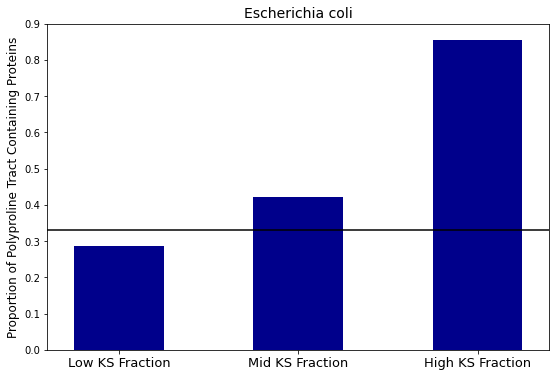

In [31]:
expected = len(PPP_ks_table.ks_stat)/len(df_ecol.ks_stat)
figure(figsize = (9,6))
#plt.bar([1,2,3],[1.0,1.0,1.0],fill = False, width = 0.5,
#        tick_label = ["Low KS fraction (<0.15)","Mid KS fraction (>0.15 & <0.3)","High KS fraction (>0.3)"])
plt.bar([1,2,3],ratios_ecol, color = "darkblue",width = 0.5,
       tick_label = ["Low KS Fraction", "Mid KS Fraction", "High KS Fraction"])
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 0.9)
plt.ylabel("Proportion of Polyproline Tract Containing Proteins", fontsize = 12)
plt.title("Escherichia coli", fontsize = 14)
plt.plot([0,4],[expected,expected], color = "black")
plt.savefig(save_path + 'ecoli_proportions.pdf')

In [29]:
det_p_values(PPP_ks_table, df_ecol, sections_ecol)

[1.9370187036408397e-05, 2.551556586422312e-05, 1.3452694340452054e-31]

## Looking at the kernel density estimates

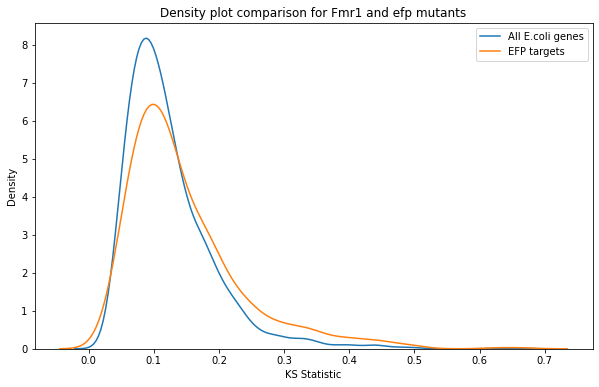

In [32]:
figure(figsize = (10,6))
sns.kdeplot(df_ecol.ks_stat, label = "All E.coli genes")
sns.kdeplot(PPP_ks_table.ks_stat, label = "EFP targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and efp mutants")
plt.legend()